Total amount of images: 354
Dataset contains 708 image pairs
Train contains 566 image pairs
Validation contains 70 image pairs
Test contains 72 image pairs


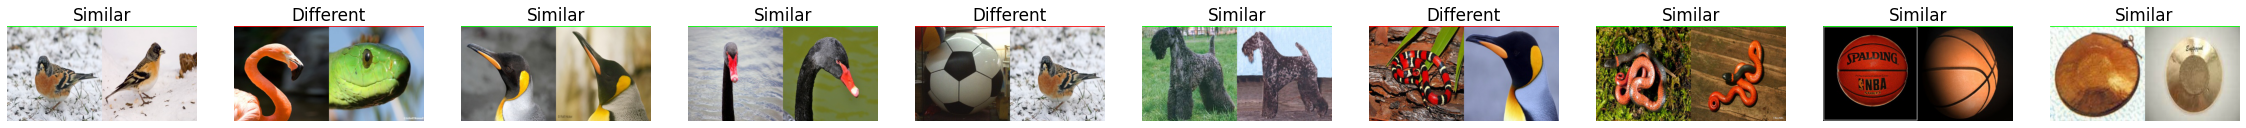

In [1]:
import sys
sys.path.append('../../utility')
import util
import numpy as np

folders = util.load_images('../../data/dataset_pairs')
data, labels = util.create_pairs(folders)
data, labels = util.shuffle_data(data, labels)
data_split, labels_split = util.split_data(data, labels)
data_train, data_val, data_test = data_split
labels_train, labels_val, labels_test = labels_split

print('Dataset contains', data.shape[0], 'image pairs')
print('Train contains', data_train.shape[0], 'image pairs')
print('Validation contains', data_val.shape[0], 'image pairs')
print('Test contains', data_test.shape[0], 'image pairs')

util.visualize(data_train, labels_train)

In [2]:
# Import libraries and modules
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Lambda
from keras.layers import Input
from keras.layers import BatchNormalization, Dot
from keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from keras.applications.mobilenet_v2 import MobileNetV2

In [3]:
input_shape = (224, 224, 3)

# Source <https://keras.io/examples/vision/siamese_contrastive/>

embedding_extractor = Sequential(name='embedding_extractor')
base_model = MobileNetV2(input_shape=(input_shape), include_top = False, weights='imagenet')
base_model.trainable = False
embedding_extractor.add(base_model)
embedding_extractor.add(Dropout(0.3))
embedding_extractor.add(Dense(1280, activation='relu'))
embedding_extractor.add(GlobalAveragePooling2D())

embedding_extractor.summary()

# Input pair
input_image_1 = Input(input_shape)
input_image_2 = Input(input_shape)

# Output pair
encoded_image_1 = embedding_extractor(input_image_1)
encoded_image_2 = embedding_extractor(input_image_2)

similarity = Dot(axes=(1), normalize=True)([encoded_image_1, encoded_image_2])

# Full Model
siamese = Model(inputs=[input_image_1, input_image_2], outputs=similarity, name='model')

# # Model
# feature_extraction_model = Model(inputs=[input_image_1, input_image_2], outputs=[encoded_image_1, encoded_image_2], name='feature_extractor')
# feature_extraction_model.summary()

def loss(margin=1):
    """Provides 'constrastive_loss' an enclosing scope with variable 'margin'.

    Arguments:
        margin: Integer, defines the baseline for distance for which pairs
                should be classified as dissimilar. - (default is 1).

    Returns:
        'constrastive_loss' function with data ('margin') attached.
    """

    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        """Calculates the constrastive loss.

        Arguments:
            y_true: List of labels, each label is of type float32.
            y_pred: List of predictions of same length as of y_true,
                    each label is of type float32.

        Returns:
            A tensor containing constrastive loss as floating point value.
        """

        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)

        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss

siamese.compile(loss=loss(margin=0.5), optimizer=Adam(), metrics=["accuracy"])
siamese.summary()

Model: "embedding_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 dropout (Dropout)           (None, 7, 7, 1280)        0         
                                                                 
 dense (Dense)               (None, 7, 7, 1280)        1639680   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
Total params: 3,897,664
Trainable params: 1,639,680
Non-trainable params: 2,257,984
_________________________________________________________________
Model: "model"
______________

In [4]:
history = siamese.fit(
    [data_train[:, 0], data_train[:, 1]],
    labels_train.astype(float),
    validation_data=([data_val[:, 0], data_val[:, 1]], labels_val),
    batch_size=32,
    epochs=5,
)

Epoch 1/5
18/18 [==============================] - 14s 594ms/step - loss: 0.0946 - accuracy: 0.8375 - val_loss: 0.0042 - val_accuracy: 0.9857
Epoch 2/5
18/18 [==============================] - 10s 546ms/step - loss: 0.0028 - accuracy: 0.9947 - val_loss: 9.0373e-04 - val_accuracy: 0.9857
Epoch 3/5
18/18 [==============================] - 10s 540ms/step - loss: 4.9755e-04 - accuracy: 0.9965 - val_loss: 6.7687e-04 - val_accuracy: 0.9857
Epoch 4/5
18/18 [==============================] - 10s 538ms/step - loss: 2.7190e-04 - accuracy: 0.9982 - val_loss: 6.0261e-04 - val_accuracy: 0.9857
Epoch 5/5
18/18 [==============================] - 10s 554ms/step - loss: 1.9373e-04 - accuracy: 1.0000 - val_loss: 5.5988e-04 - val_accuracy: 0.9857


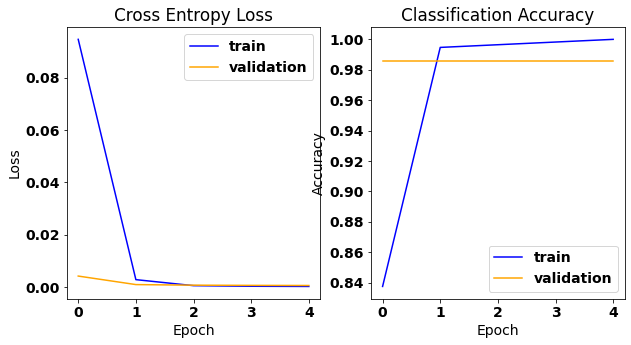

In [5]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
    	
	plt.rcParams.update({'text.color': '#000000'})
	# plot loss
	fig, ax = plt.subplots(1, 2, figsize=(10, 5))
	ax[0].set_title('Cross Entropy Loss')
	ax[0].set_xlabel('Epoch')
	ax[0].set_ylabel('Loss')
	ax[0].plot(history.history['loss'], color='blue', label='train')
	ax[0].plot(history.history['val_loss'], color='orange', label='validation')
	ax[0].legend()

	# plot accuracy
	ax[1].set_title('Classification Accuracy')
	ax[1].set_xlabel('Epoch')
	ax[1].set_ylabel('Accuracy')
	ax[1].plot(history.history['accuracy'], color='blue', label='train')
	ax[1].plot(history.history['val_accuracy'], color='orange', label='validation')
	ax[1].legend()
	
	plt.show()

summarize_diagnostics(history)

In [6]:
score = siamese.evaluate(
    [data_test[:, 0], data_test[:, 1]], 
    labels_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.0018827664898708463
Test accuracy: 1.0


In [7]:
embedding_extractor.save('./contrastive_loss_embedding_extractor.h5')

siamese.save('./siamese_model/contrastive_loss_siamese.h5', include_optimizer=False)

In [8]:
!tensorflowjs_converter --input_format keras --weight_shard_size_bytes 1073741824 ./contrastive_loss_embedding_extractor.h5 .

In [ ]:
!tensorflowjs_converter --input_format keras --weight_shard_size_bytes 1073741824 ./siamese_model/contrastive_loss_siamese.h5 ./siamese_model/